In [1]:
import pandas as pd
import numpy as np

import re
import string
import os
import spacy
import en_core_web_lg
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import  LinearSVC

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam
from utils import _get_basic_features , _get_wordcounts , _get_ngram

In [2]:
tweet = pd.read_csv("train.csv")

In [103]:
tweet.head(5)


,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0,"[-0.020768244, 0.053068247, -0.15192825, -0.27..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0,"[-0.015307656, 0.06607368, -0.09196319, -0.087..."
3,6,NaN,NaN,"13,0 people receive wildfires evacuation order...",1,57,8,7.125000,1,1,0,1,0,"[-0.15878788, 0.18140274, 0.012378874, -0.1909..."
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [4]:
tweet.shape

(7613, 5)

In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploraatory Data Analysis

In [6]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

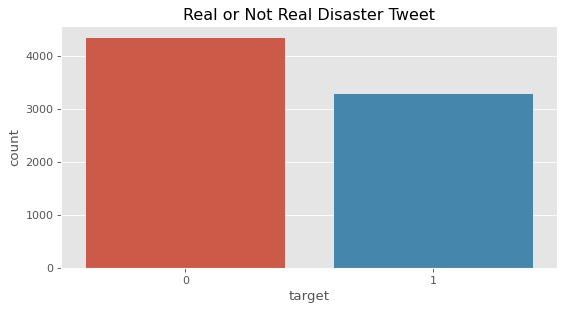

In [7]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [8]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Number of Charecters Distibution in Tweets


In [9]:
# !pip install spacy==2.2.3
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_lg
# !pip install beautifulsoup4==4.9.1
# !pip install textblob==0.15.3
# !pip install ktrain

In [12]:
tweet = _get_basic_features(tweet)

In [13]:
tweet = pd.DataFrame(tweet)
tweet.head(5)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


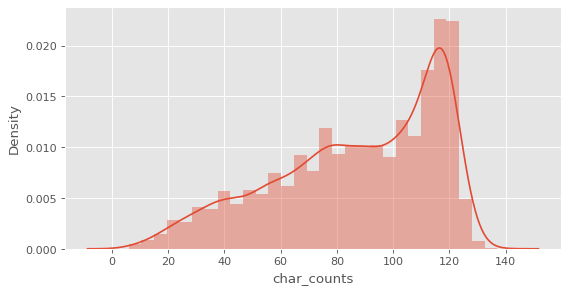

In [14]:
sns.distplot(tweet['char_counts'])

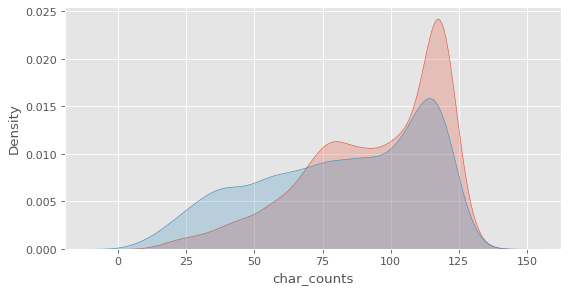

In [15]:
sns.kdeplot(tweet[tweet['target'] == 1]['char_counts'],shade=True)
sns.kdeplot(tweet[tweet['target'] == 0]['char_counts'],shade=True)

Number of words ,average word length,stopwords distribution in tweets

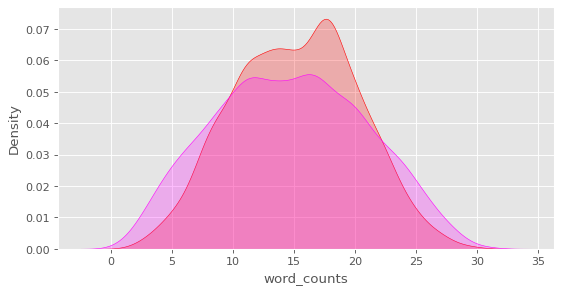

In [16]:
sns.kdeplot(tweet[tweet['target'] == 1]['word_counts'],shade=True , color='red')
sns.kdeplot(tweet[tweet['target'] == 0]['word_counts'],shade=True , color='magenta')

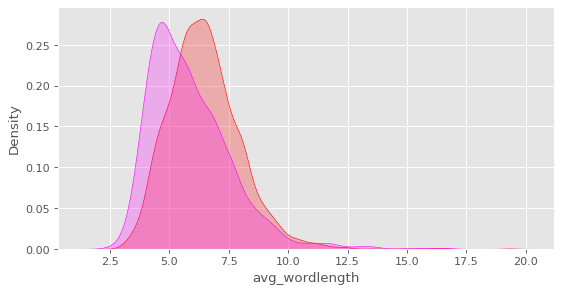

In [17]:
sns.kdeplot(tweet[tweet['target'] == 1]['avg_wordlength'],shade=True , color='red')
sns.kdeplot(tweet[tweet['target'] == 0]['avg_wordlength'],shade=True , color='magenta')

Most and least common words

In [18]:
freqs = _get_wordcounts(tweet['text'])


In [19]:
bigram = _get_ngram(tweet, 'text', ngram_range=2)
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

In [20]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove duplicates
    tweet = re.sub("(.)\\1{2,}", "\\1", tweet)
    # remove emails
    tweet = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # # tokenize tweets
    # tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
    #                            reduce_len=True)
    # tweet_tokens = tokenizer.tokenize(tweet)

    # tweets_clean = []
    # for word in tweet_tokens:
    #     if (word not in stopwords_english and  # remove stopwords
    #             word not in string.punctuation):  # remove punctuation
    #         # tweets_clean.append(word)
    #         stem_word = stemmer.stem(word)  # stemming word
    #         tweets_clean.append(stem_word)

    return tweet

In [21]:
tweet['text'] = tweet['text'].apply(lambda x: process_tweet(x))


In [22]:
tweet.head(5)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,0 people receive wildfires evacuation order...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,72,16,4.500000,6,2,0,0,0


In [23]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

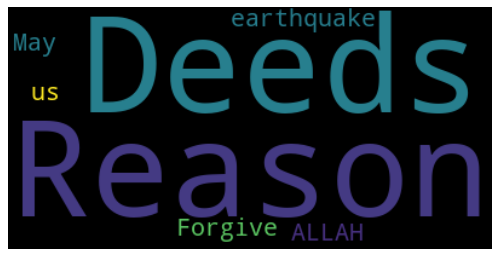

In [24]:
# Start with one review:
t1 = tweet.text[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(t1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
# t1 = tweet.groupby(tweet['target'] == 1).text

Classification with TF-IDF and SVM

In [26]:
text = tweet['text']
y = tweet['target']

In [27]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [28]:
X.shape

(7613, 16311)

In [29]:
X_trian,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [30]:
def run_svm(clf,X_trian,y_train,X_test,y_test):
  clf.fit(X_trian,y_train)
  y_pred = clf.predict(X_test)
  print('Classification Report: \n',classification_report(y_test,y_pred))




In [31]:
clf = LinearSVC()
run_svm(clf,X_trian,y_train,X_test,y_test)

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       869
           1       0.81      0.68      0.74       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [32]:
nlp = en_core_web_lg.load()

In [33]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [34]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))


In [35]:
tweet.head(5)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0,"[-0.020768244, 0.053068247, -0.15192825, -0.27..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0,"[-0.015307656, 0.06607368, -0.09196319, -0.087..."
3,6,NaN,NaN,"13,0 people receive wildfires evacuation order...",1,57,8,7.125000,1,1,0,1,0,"[-0.15878788, 0.18140274, 0.012378874, -0.1909..."
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [36]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1,1)

In [37]:
X.shape

(7613, 1)

In [38]:
X = np.concatenate(np.concatenate(X,axis=0),axis=0).reshape(-1,300)
X.shape

(7613, 300)

In [39]:
y = tweet['target']


In [40]:
X_trian,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

clf = LinearSVC()
run_svm(clf,X_trian,y_train,X_test,y_test)


Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.89      0.84       869
           1       0.83      0.72      0.77       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.81      0.81      0.81      1523



Word embeddings and classification

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [42]:
token = Tokenizer()
token.fit_on_texts(text)

In [43]:
vocab_size = len(token.word_index) + 1
vocab_size

17344

In [44]:
print(token.word_index)

{'the': 1, 'a': 2, 'in': 3, 'to': 4, 'of': 5, 'i': 6, 'and': 7, 'is': 8, 'for': 9, 'on': 10, 'you': 11, 'my': 12, 'with': 13, 'that': 14, 'it': 15, 'at': 16, 'by': 17, 'this': 18, 'from': 19, 'are': 20, 'be': 21, 'was': 22, 'have': 23, 'like': 24, 'as': 25, 'me': 26, 'up': 27, 'amp': 28, 'but': 29, 'just': 30, 'so': 31, 'not': 32, 'your': 33, 'out': 34, 'no': 35, 'after': 36, 'will': 37, 'all': 38, 'an': 39, 'has': 40, 'fire': 41, "i'm": 42, 'when': 43, 'if': 44, 'we': 45, 'get': 46, 'now': 47, 'new': 48, 'about': 49, 'more': 50, 'or': 51, '2': 52, 'what': 53, 'people': 54, 'he': 55, 'they': 56, 'one': 57, 'been': 58, 'how': 59, 'over': 60, 'who': 61, "it's": 62, 'into': 63, "don't": 64, 'do': 65, 'news': 66, "'": 67, 'can': 68, 'disaster': 69, 'emergency': 70, 'video': 71, 'there': 72, 'police': 73, 'than': 74, 'her': 75, 'would': 76, 'u': 77, '3': 78, 'still': 79, 'his': 80, 'some': 81, 'were': 82, 'body': 83, 'burning': 84, 'back': 85, 'storm': 86, 'us': 87, 'day': 88, 'california':

In [45]:
encoded_text = token.texts_to_sequences(text)
print(encoded_text)

[[112, 4442, 20, 1, 845, 5, 18, 340, 126, 1571, 4443, 87, 38], [184, 41, 218, 778, 6623, 6624, 1711], [38, 1712, 1572, 4, 6625, 3, 6626, 20, 127, 6627, 17, 1713, 35, 421, 255, 51, 2084, 3, 747, 1370, 20, 1131], [813, 376, 54, 4444, 1458, 255, 1370, 3, 89], [30, 90, 1262, 18, 317, 19, 6628, 2085, 25, 256, 19, 1458, 6629, 63, 2, 178], [2817, 401, 89, 1459, 717, 846, 3, 650, 6630, 547, 4, 1132, 402, 41, 6631, 1458], [210, 69, 878, 287, 1189, 847, 263, 5, 1714, 3, 6632, 1017, 2378, 1460], [42, 10, 219, 5, 1, 1875, 7, 6, 68, 107, 2, 41, 3, 1, 4445], [403, 39, 70, 255, 1263, 47, 3, 1, 601, 848, 1, 748], [42, 2379, 14, 1, 497, 8, 288, 4, 112, 264], [573, 54, 619, 19, 1, 265, 452, 31, 620], [849, 548, 2818, 8, 224, 2819, 3468, 674, 2, 718, 6, 191, 3, 548, 2818, 53, 163, 6, 308, 65, 53, 163, 6, 308, 65, 6633, 263], [2820, 263, 2086, 6634, 2818, 955, 51, 1573, 621, 341, 779, 3469], [210, 3, 4446, 915, 45, 1715, 4446], [228, 4, 178, 422, 10, 2380, 3, 2821, 124, 100, 342], [693, 27, 94], [6, 108, 

In [46]:
max_len = 40
X = pad_sequences(encoded_text,maxlen=max_len,padding='post')


In [47]:
print(X)

[[ 112 4442   20 ...    0    0    0]
 [ 184   41  218 ...    0    0    0]
 [  38 1712 1572 ...    0    0    0]
 ...
 [2722 2327  689 ...    0    0    0]
 [  73 1117   36 ...    0    0    0]
 [   1  200   50 ...    0    0    0]]


In [48]:
X.shape

(7613, 40)

In [49]:
X_trian,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [51]:
vec_size =100
model = Sequential()
model.add(Embedding(vocab_size,vec_size,input_length=max_len))

model.add(Conv1D(32,2 ,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1,activation='sigmoid'))



In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           1734400   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [53]:
%%time
model.compile(optimizer='adam' , loss='binary_crossentropy' , metrics=['accuracy'])
model.fit(X_trian,y_train,epochs=5,validation_data=(X_test,y_test))


Epoch 1/5
191/191 [==============================] - 12s 21ms/step - loss: 0.6793 - accuracy: 0.5774 - val_loss: 0.5710 - val_accuracy: 0.7492
Epoch 2/5
191/191 [==============================] - 3s 18ms/step - loss: 0.5053 - accuracy: 0.7816 - val_loss: 0.4747 - val_accuracy: 0.7919
Epoch 3/5
191/191 [==============================] - 3s 18ms/step - loss: 0.3310 - accuracy: 0.8692 - val_loss: 0.4627 - val_accuracy: 0.8024
Epoch 4/5
191/191 [==============================] - 3s 18ms/step - loss: 0.2303 - accuracy: 0.9136 - val_loss: 0.5138 - val_accuracy: 0.7722
Epoch 5/5
191/191 [==============================] - 3s 18ms/step - loss: 0.1676 - accuracy: 0.9384 - val_loss: 0.5588 - val_accuracy: 0.7715
CPU times: user 28.7 s, sys: 2.32 s, total: 31.1 s
Wall time: 25.9 s


In [62]:
def get_encoded(x):
  x = process_tweet(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x,maxlen=max_len,padding='post')
  return x


In [63]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [64]:
vec

array([[  6, 163,   4, 107,  18,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

In [65]:
np.argmax(model.predict(vec), axis = -1)

array([0])

In [67]:
from ktrain import text
import ktrain


In [68]:
(X_train,y_train) , (X_test,y_test) , preproc = text.texts_from_df(train_df=tweet,text_column='text' , label_columns='target',maxlen=40,preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [69]:
model = text.text_classifier(name='bert',train_data=(X_train,y_train),preproc=preproc)


Is Multi-Label? False
maxlen is 40
done.


In [70]:
learner = ktrain.get_learner(model=model,train_data=(X_train,y_train),val_data=(X_test,y_test),batch_size=64)


In [71]:
learner.fit_onecycle(lr=2e-5,epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 105s 803ms/step - loss: 0.5475 - accuracy: 0.7167 - val_loss: 0.4288 - val_accuracy: 0.8163


In [72]:
learner.fit_onecycle(lr=2e-4,epochs=3)




begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 83s 766ms/step - loss: 0.3888 - accuracy: 0.8383 - val_loss: 0.5064 - val_accuracy: 0.7966
Epoch 2/3
108/108 [==============================] - 83s 767ms/step - loss: 0.3362 - accuracy: 0.8656 - val_loss: 0.5071 - val_accuracy: 0.7756
Epoch 3/3
108/108 [==============================] - 83s 770ms/step - loss: 0.2047 - accuracy: 0.9254 - val_loss: 0.5901 - val_accuracy: 0.8071


In [86]:
test = pd.read_csv('test.csv')
predictor = ktrain.get_predictor(learner.model,preproc)
data = ['i met you today by accident', 'i got today car accident, i am injured']
predicted_prices = predictor.predict(data, return_proba=True)

predicted_prices

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:216: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


array([[0.9558884 , 0.04411162],
       [0.0184982 , 0.98150176]], dtype=float32)

In [77]:
# Read the test data
test = pd.read_csv('test.csv')


In [99]:
# y_pred = predictor.predict(data, return_proba=True)
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [91]:
predictor.predict(data[0])

'not_target'

In [120]:
classes = predictor.get_classes()

with open("text.txt") as readfile:
  data = readfile.read().strip().split("\n")

In [125]:
for each_data in data:
  y_pred = predictor.predict(each_data)
  predictor_class = classes.index(y_pred)
  my_submission = pd.DataFrame({"id" : test['id'] , "target" : predictor_class})
  my_submission.to_csv('submission.csv', index=False)
  
